In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError
from torch.utils.data import DataLoader, TensorDataset

from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config, instantiate_from_config

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_prediction.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]


# dataset
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)


# load dataloader
ori_dl = dl_info_train["dataloader"]
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lossfn = nn.L1Loss()
lr = 0.001


In [3]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:,:-1,:].float().to(device)
                y_train = data[:,-1:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [4]:
def evaluate_model(model, dataloader):
    model.eval()
    
    # define loss for comparison
    l1loss = nn.L1Loss()
    l2loss = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    
    total_l1 = 0
    total_l2 = 0

    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :(seq_length - 1), :].float().to(device)
            y_test = data[:, (seq_length - 1):, :1].float().to(device)
            mean = mean[:, :, :1].float().to(device)
            std = std[:, :, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            
            total_l1 += l1loss(y_pred, y_test) * len(data)
            total_l2 += l2loss(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_l1 /= len(dataloader.dataset)
    total_l2 /= len(dataloader.dataset)
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_l1, total_l2, mape_loss, predictions, true_vals

In [5]:
# Initialize Diffusion_TS Model
diffusion_adversarial = instantiate_from_config(configs['model']).to(device)
diffusion_adversarial.load_state_dict(torch.load("check_points/stock_24/model_50000.pth"))

<All keys matched successfully>

In [8]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, ori_dl, lossfn, optimizer_ori, num_epochs=2000, description="Original")


In [10]:
# grid search
# for e in [5000, 6000, 7000, 8000, 10000]:
#     model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
#     optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
#     train_model(model_ori, ori_dl, lossfn, optimizer_ori, num_epochs=e, description="Original")
#     ori_l1, ori_l2, ori_mape, ori_pred_y, true_y = evaluate_model(model_ori, test_dl)
#     print(f"epoch : {e} \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {ori_mape:0.5f} ")


Original loss: 0.022251: 100%|██████████| 5000/5000 [05:44<00:00, 14.50it/s]


epoch : 5000 	 L1 loss: 0.60304 	 L2 Loss : 0.68117 	 MAPE loss : 0.01690 


Original loss: 0.017042: 100%|██████████| 6000/6000 [09:23<00:00, 10.64it/s]


epoch : 6000 	 L1 loss: 0.59568 	 L2 Loss : 0.66153 	 MAPE loss : 0.01663 


Original loss: 0.255071:   2%|▏         | 129/7000 [00:13<11:56,  9.59it/s]


KeyboardInterrupt: 

In [6]:
def adv_train_model(model, dataloader, criterion, optimizer, epsilon=0.01, num_epochs=100, description=""):
    model.train()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    adv_data = []
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            running_loss = 0.0
            for data in dataloader:
                x_train = data[:, :-1, :].float().to(device)
                y_train = data[:, -1:, 0].float().to(device)
                x_train.requires_grad = True
                
                # Standard training forward pass
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                
                # Generate adversarial examples
                grad = x_train.grad.data
                x_adv = (x_train + epsilon * grad.sign()).clamp(-4, 4).detach()
                
                if e+1 == num_epochs: 
                    adv_data.append(x_adv.cpu())

                # Adversarial training forward pass
                x_adv.requires_grad = False
                outputs_adv = model(x_adv)
                loss_adv = criterion(outputs_adv, y_train)
                loss_adv.backward()
                optimizer.step()
                
                running_loss += loss_adv.item()
            
            avg_loss = running_loss / len(dataloader)
            pbar.set_description(f"{description} loss: {avg_loss:.6f}")
            
    return adv_data

In [14]:
e = 4000
epsilon = 0.5
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
adv_data = adv_train_model(model_ori, ori_dl, lossfn, optimizer_ori, epsilon=epsilon, num_epochs=e, description="Original")

ori_l1, ori_l2, ori_mape, ori_pred_y, true_y = evaluate_model(model_ori, test_dl)
print(f"epoch : {e} epsilon : {epsilon} \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {ori_mape:0.5f} ")

  0%|          | 0/4000 [00:00<?, ?it/s]

Original loss: 0.463240: 100%|██████████| 4000/4000 [02:30<00:00, 26.57it/s]


epoch : 4000 epsilon : 0.5 	 L1 loss: 0.60086 	 L2 Loss : 0.67610 	 MAPE loss : 0.01669 


In [15]:
adv_data_2 = torch.concat(adv_data)

In [16]:
adv_data_2.shape

torch.Size([3456, 23, 5])

In [17]:
data = []
for x in ori_dl:
    data.append(x)
    
data2 = torch.concat(data)
data2 = data2[:, :-1, :]

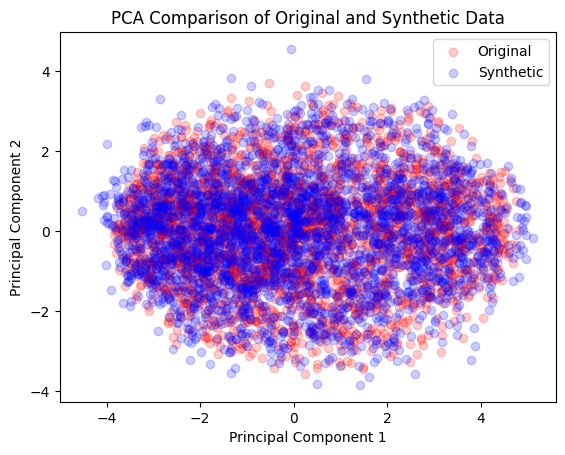

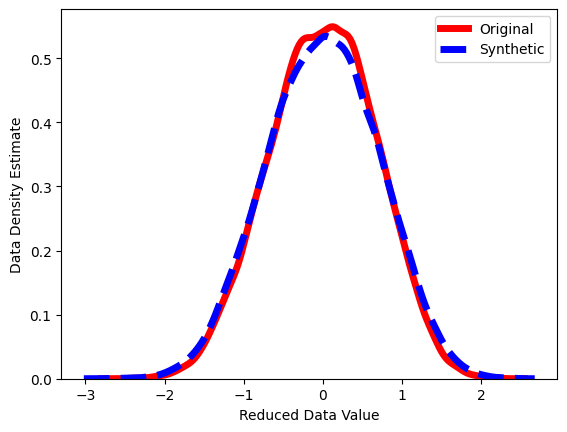

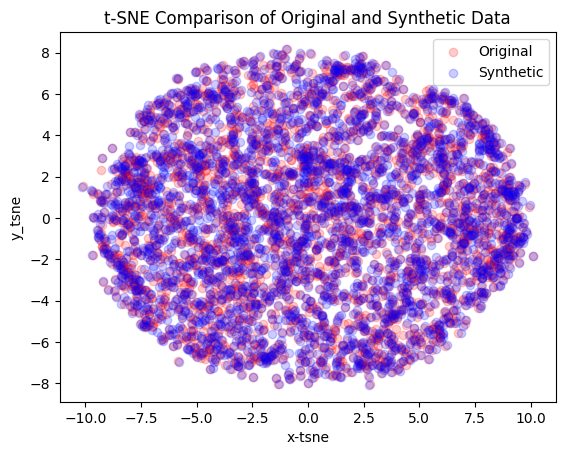

In [18]:
from utils.visualize import visualize_kernel, visualize_pca, visualize_tsne

visualize_pca(data2, adv_data_2, 3000)
visualize_kernel(data2, adv_data_2, 3000)
visualize_tsne(data2, adv_data_2, 3000)

In [19]:
# quantatitive metrics
# cross correlation score

from metrics.cross_correlation import CrossCorrelLoss
from utils.utils import display_scores

iterations = 5
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

x_real = data2
x_fake = adv_data_2

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 0.07561904191970825 

Iter 1:  cross-correlation = 0.08629296720027924 

Iter 2:  cross-correlation = 0.07501031458377838 

Iter 3:  cross-correlation = 0.06524369865655899 

Iter 4:  cross-correlation = 0.06807658821344376 

Final Score: 0.07405 ± 0.01014


In [7]:
epsilons = [0.5, 0.7, 1, 1.5]
num_epochs = [2000, 3000, 4000, 5000]

In [8]:
# Train on original data
for ep in epsilons:
    for e in num_epochs:
        model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
        optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
        adv_train_model(model_ori, ori_dl, lossfn, optimizer_ori, epsilon=ep, num_epochs=e, description="Original")

        ori_l1, ori_l2, ori_mape, ori_pred_y, true_y = evaluate_model(model_ori, test_dl)
        print(f"epsilon : {ep}, epoch : {e} \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {ori_mape:0.5f} ")

Original loss: 0.908852:  12%|█▏        | 237/2000 [00:08<01:04, 27.25it/s]


KeyboardInterrupt: 

In [7]:
data = []
for x in ori_dl:
    data.append(x)

data = torch.concat(data)


In [8]:
test_data = []
for x, *_ in test_dl:
    test_data.append(x)
test_data = torch.concat(test_data)


In [9]:
data_1 = data[:2500, :, :]
test_data_1 = test_data[:2500, : ,:]

In [10]:
test_data_1 = test_data_1.cpu()

torch.Size([2500, 24, 5])

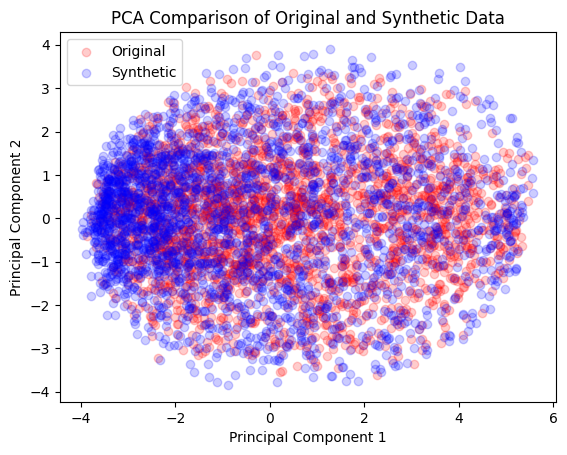

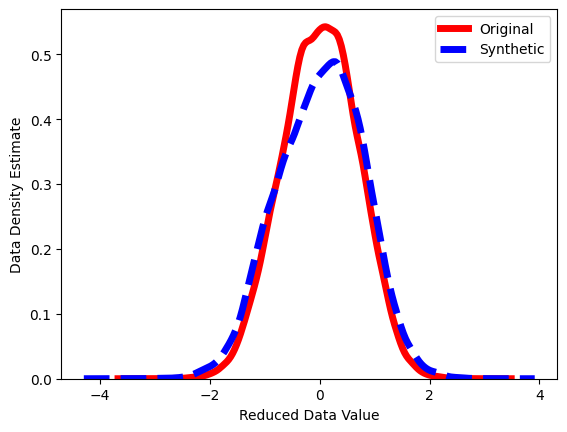

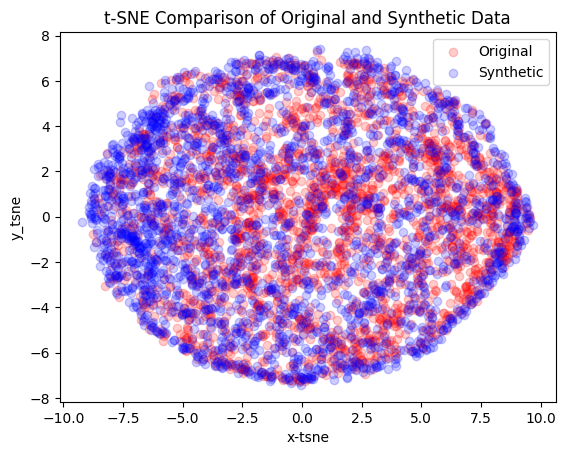

In [11]:
from utils.visualize import visualize_kernel, visualize_pca, visualize_tsne

visualize_pca(data_1, test_data_1, 2500)
visualize_kernel(data_1, test_data_1, 2500)
visualize_tsne(data_1, test_data_1, 2500)

In [12]:
# quantatitive metrics
# cross correlation score

from metrics.cross_correlation import CrossCorrelLoss
from utils.utils import display_scores

iterations = 5
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

x_real = data_1
x_fake = test_data_1

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 0.14449246227741241 

Iter 1:  cross-correlation = 0.1290440559387207 

Iter 2:  cross-correlation = 0.16519419848918915 

Iter 3:  cross-correlation = 0.118550144135952 

Iter 4:  cross-correlation = 0.16703328490257263 

Final Score: 0.14486 ± 0.02669


In [52]:
data = data[:3000, :, :]

In [47]:
data_fake = diffusion_adversarial.generate_mts(3000)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [02:24<00:00,  3.47it/s]


/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


OutOfMemoryError: CUDA out of memory. Tried to allocate 162.00 MiB. GPU 

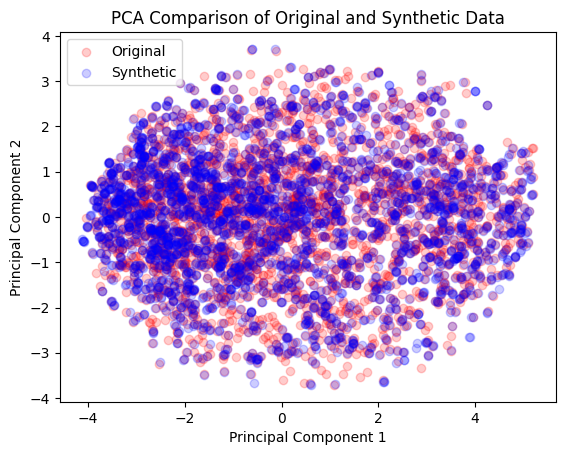

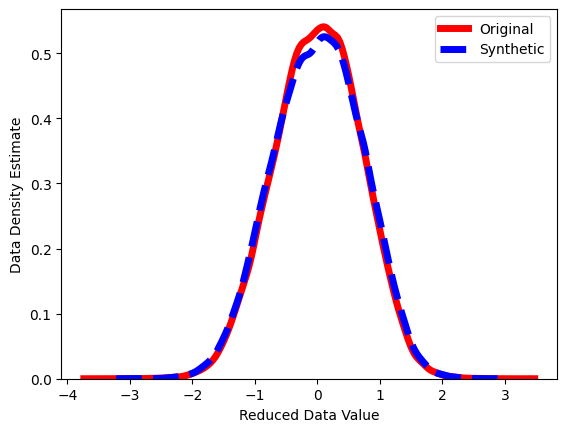

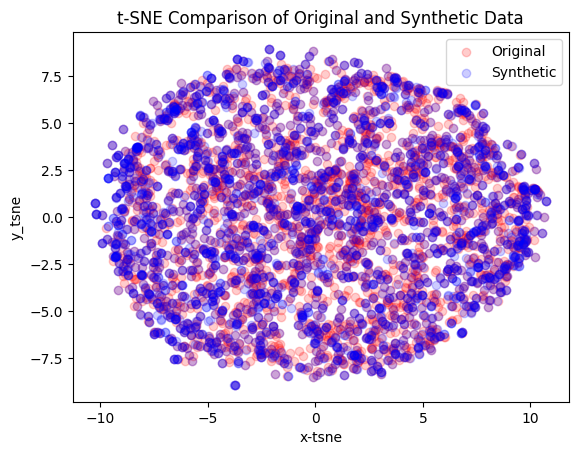

In [54]:
from utils.visualize import visualize_kernel, visualize_pca, visualize_tsne

visualize_pca(data, data_fake, 3000)
visualize_kernel(data, data_fake, 3000)
visualize_tsne(data, data_fake, 3000)

In [7]:
# Test on test data
ori_l1, ori_l2, ori_mape, ori_pred_y, true_y = evaluate_model(model_ori, test_dl)
print(f"Original Model : \t L1 loss: {ori_l1:0.5f} \t L2 Loss : {ori_l2:0.5f} \t MAPE loss : {ori_mape:0.5f} ")

Original Model : 	 L1 loss: 0.62154 	 L2 Loss : 0.72201 	 MAPE loss : 0.01743 


In [ ]:
loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)
print(f"Synthetic + Original Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
print(f"AdvSyn + Original Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


In [5]:
# Generate adversarial data
ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
adv_data = diffusion_adversarial.generate_adversarial(ori_data,
                                                      predictor=diffusion_adversarial.predictor.to(device))

# Concatenate adversarial data with original data for training
combined_data = torch.cat([ori_data, adv_data], dim=0)
from torch.utils.data import DataLoader
combined_loader = DataLoader(combined_data, batch_size=128, shuffle=True)

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [29]:
import gc

# At the beginning or end of training
torch.cuda.empty_cache()
gc.collect()


7403

Original loss: 0.044517: 100%|██████████| 2000/2000 [00:49<00:00, 40.16it/s]


In [8]:
# Train on synthetic data
ori_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))).to(device)
fake_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))).to(device)
combined_dataset = torch.concatenate([ori_dataset,fake_dataset])
from torch.utils.data import DataLoader
ori_fake_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

model_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_fake = nn.L1Loss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)
train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=2000, description="Synthetic + Original")

Synthetic + Original loss: 0.026017: 100%|██████████| 2000/2000 [01:30<00:00, 22.11it/s]


In [9]:
# Train your GRU model using this combined data
model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)

criterion_ori_fake = nn.L1Loss()
optimizer_ori_fake = Adam(model_ori_fake.parameters(), lr=lr)
train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=2000, description="AdvSyn + Original")

AdvSyn + Original loss: 0.025441: 100%|██████████| 2000/2000 [01:30<00:00, 22.10it/s]


In [12]:
loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
print(f"Synthetic + Original Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
print(f"AdvSyn + Original Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


Original Model : 	 L1 loss: 0.62494 	 L2 Loss : 0.71905 	 MAPE loss : 0.01758 
Synthetic + Original Model : 	 L1 loss: 0.61206 	 L2 Loss : 0.70999 	 MAPE loss : 0.01717 
AdvSyn + Original Model : 	 L1 loss: 0.59447 	 L2 Loss : 0.66203 	 MAPE loss : 0.01648 


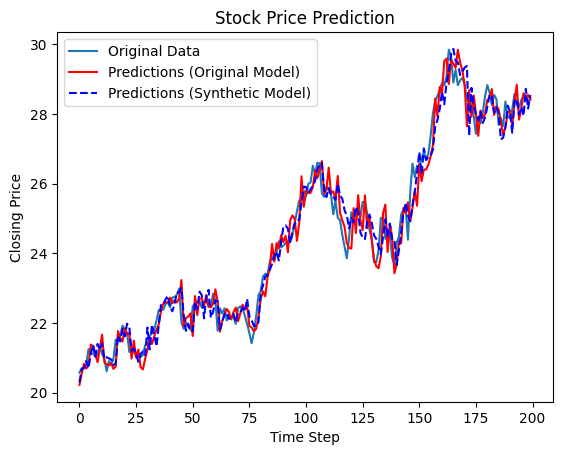

In [13]:
# Visualize predictions
plt.figure()
plt.plot(true_y[100:300], label='Original Data')
plt.plot(pred_y_ori[100:300], label='Predictions (Original Model)', linestyle='-', color='r')
plt.plot(pred_y_ori_fake[100:300], label='Predictions (Synthetic Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


## additional training

In [14]:
# # Generate adversarial data
# ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
# adv_data = diffusion_adversarial.generate_adversarial(ori_data,
#                                                       predictor=model_ori_fake.to(device))

# # Concatenate adversarial data with original data for training
# combined_data = torch.cat([ori_data, adv_data], dim=0)
# from torch.utils.data import DataLoader
# combined_loader = DataLoader(adv_data, batch_size=128, shuffle=True)

In [15]:
# import gc

# # At the beginning or end of training
# torch.cuda.empty_cache()
# gc.collect()


In [16]:
# train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=250, description="Synthetic + Original")
# train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=250, description="Synthetic")
# train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=250, description="Original")

In [17]:
# loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
# loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
# loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

# print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
# print(f"Fake Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
# print(f"OriFake Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


In [18]:
for i in range(50):
    # Generate adversarial data
    ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
    adv_data = diffusion_adversarial.generate_adversarial(ori_data,
                                                        predictor=model_ori_fake.to(device))

    # Concatenate adversarial data with original data for training
    combined_data = torch.cat([ori_data, adv_data], dim=0)
    combined_loader = DataLoader(adv_data, batch_size=128, shuffle=True)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=500, description="AdvSyn + Original")
    # train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=500, description="Synthetic")
    # train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=500, description="Original")
    
    # loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
    # loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
    loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

    # print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
    # print(f"Fake Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
    print(f"OriFake Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")



AdvSyn + Original loss: 0.022081: 100%|██████████| 500/500 [00:11<00:00, 42.34it/s]


OriFake Model : 	 L1 loss: 0.59386 	 L2 Loss : 0.66307 	 MAPE loss : 0.01641 


AdvSyn + Original loss: 0.019209:  17%|█▋        | 84/500 [00:01<00:09, 42.52it/s]


KeyboardInterrupt: 